# EDA the Gaia DR3 Full Catalog

In [1]:
# generate edges 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc

pd.options.display.max_rows = 200

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
from pyspark import SparkContext   
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession

sc = spark.sparkContext
sqlsc = SQLContext(sc)
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

## Read the data 

In [4]:
import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
filepath = \
"hdfs://spark00:54310/common/data/catalog/external-catalogs/parquet/gaia-dr3/raw/"

#### Read all parquets at once

In [6]:
%%time
# Read all parquets in the directory
rawdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(filepath)

CPU times: user 619 µs, sys: 882 µs, total: 1.5 ms
Wall time: 3 s


## EDA the full gaia catalog

In [7]:
#rawdf.printSchema()
#print(rawdf.columns)

In [8]:
df = rawdf.select('source_id','ra','dec','parallax','pm','pmra','pmdec', \
                  'astrometric_excess_noise','ruwe','classprob_dsc_combmod_quasar', \
                  'classprob_dsc_combmod_galaxy','classprob_dsc_combmod_star')

In [9]:
df.cache()

DataFrame[source_id: bigint, ra: double, dec: double, parallax: double, pm: float, pmra: double, pmdec: double, astrometric_excess_noise: float, ruwe: float, classprob_dsc_combmod_quasar: float, classprob_dsc_combmod_galaxy: float, classprob_dsc_combmod_star: float]

In [10]:
%%time
df.describe().toPandas().transpose()

CPU times: user 17.1 ms, sys: 2.93 ms, total: 20.1 ms
Wall time: 1min 43s


,0,1,2,3,4
summary,count,mean,stddev,min,max
source_id,1811709771,4.3515610592999455E18,1.64011514434601574E18,4295806720,6917528997577384320
ra,1811709771,229.12434364249685,77.7851076787804,3.4096239126626443E-7,359.999999939548
dec,1811709771,-18.374270531226507,36.53941026762347,-89.99287859590359,89.99005196682685
parallax,1467744818,0.36636113047677127,1.0261718025894786,-187.02939637423492,768.0665391873573
pm,1467744818,6.5300357767188295,6.208413714904155,1.9370936E-4,10393.349
pmra,1467744818,-2.559096059140116,5.642731590202936,-4406.469178827325,6765.995136250774
pmdec,1467744818,-3.1158782021276537,5.752189036045851,-5817.8001940492695,10362.394206546573
astrometric_excess_noise,1811709771,1.4472481372195847,5.4133046584470215,0.0,1131.5846
ruwe,1467744818,1.0973414513193873,0.6082553477854712,0.19239865,116.016365


> 1.8 billion objects ! 

### Stellar Objects

In [11]:
%%time
rawstardf = df.filter((F.col('classprob_dsc_combmod_star') > 0.5) & (F.col('ruwe') < 1.4))

CPU times: user 350 µs, sys: 484 µs, total: 834 µs
Wall time: 10.4 ms


In [12]:
%%time
rawstardf.describe().toPandas().transpose()

CPU times: user 4.97 ms, sys: 1.26 ms, total: 6.23 ms
Wall time: 4.6 s


,0,1,2,3,4
summary,count,mean,stddev,min,max
source_id,1304979431,4.3132475589375816E18,1.72159960843961037E18,4295806720,6917528997577384320
ra,1304979431,224.78295306096888,81.18003284199818,3.4096239126626443E-7,359.999999939548
dec,1304979431,-16.595830099101722,38.30390216592704,-89.99287859590359,89.99005196682685
parallax,1304979431,0.37259322671276146,0.8913077253711832,-117.44857690096015,768.0665391873573
pm,1304979431,6.496989366913568,6.12618908576481,1.9370936E-4,10393.349
pmra,1304979431,-2.5457758901812317,5.585905279504911,-4406.469178827325,6765.995136250774
pmdec,1304979431,-3.0701227486879477,5.712451067820184,-5817.8001940492695,10362.394206546573
astrometric_excess_noise,1304979431,0.5273923610173882,0.839992122043986,0.0,17.405478
ruwe,1304979431,1.0294852843399496,0.0727080656098289,0.20452607,1.4


> 1.3 billion stars ! 

### HealPix Visualization

> healpy: https://healpy.readthedocs.io/en/latest/tutorial.html <br><br>
The choices of `nside` and projection method such as `mollview`(?) should be settled.

In [13]:
import healpy as hp

In [14]:
%time
rawstardf.limit(3).toPandas().transpose()

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs


,0,1,2
source_id,1.235499e+17,1.235499e+17,1.235499e+17
ra,4.833770e+01,4.834184e+01,4.834453e+01
dec,3.157786e+01,3.157342e+01,3.157467e+01
parallax,5.732078e-01,-6.411236e-01,1.811554e-01
pm,8.913921e+00,3.693078e+00,2.319099e+00
pmra,3.769940e+00,3.510850e+00,1.302740e+00
pmdec,-8.077471e+00,-1.145756e+00,-1.918616e+00
astrometric_excess_noise,0.000000e+00,0.000000e+00,1.783412e-01
ruwe,9.899687e-01,9.611782e-01,1.054118e+00
classprob_dsc_combmod_quasar,1.021373e-13,1.305954e-10,1.022009e-13


#### Basic Settings for HealPix

In [15]:
NSIDE = 512
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

3145728


> Still, I do not know which `NSIDE` is the best for Gaia visualizations

In [16]:
testdf = rawstardf.sample(fraction=1e-7, seed=1)

In [17]:
testdf.count()

124

#### UDF for getting HealPix indices 

In [18]:
import numpy as np
import healpy as hp
def getHealPixIndexLatLon(inlat, inlon, nside):
    lat_theta = 0.5*np.pi - np.radians(inlat)
    lon_phi = np.radians(inlon)
    #print("lat_theta/pi= ",lat_theta/np.pi)
    #print("lon_phi/pi= ",lon_phi/np.pi)
    
    return int(hp.ang2pix(nside,theta = lat_theta,phi= lon_phi,nest=True))

In [19]:
try:
    result = hp.ang2pix(NSIDE,theta=np.pi*1.5,phi =np.pi*1.5, nest=True)
except:
    result = -1

print(result)

-1


In [20]:
getHealPixIndexLatLon(0,270,NSIDE)

1944234

In [21]:
hp.ang2pix(NSIDE,theta=np.pi*0.5,phi =np.pi*1.5, nest=True)

1944234

In [22]:
hp.ang2pix(NSIDE, np.pi*0.5, np.pi*1.5, nest=True)

1944234

In [23]:
from functools import partial
healpixudf = F.udf(partial(getHealPixIndexLatLon,nside=NSIDE),T.IntegerType())

In [24]:
NSIDE

512

In [25]:
testfunc = partial(getHealPixIndexLatLon,nside=NSIDE)

In [26]:
testfunc(0,270)

1944234

In [27]:
tmpdf = testdf.withColumn('ipx512nested',healpixudf(F.col('dec'),F.col('ra')))

In [28]:
tmpdf.limit(3).toPandas().transpose()

,0,1,2
source_id,1.835930e+17,1.106625e+18,4.263210e+18
ra,7.981837e+01,9.898556e+01,2.895479e+02
dec,3.469136e+01,6.967172e+01,-2.087895e-01
parallax,8.175099e-01,8.972705e-01,3.527899e-01
pm,1.258679e+00,1.908113e+00,2.303310e+00
pmra,1.249215e+00,1.214280e+00,-1.411560e+00
pmdec,-1.540570e-01,-1.471875e+00,-1.820092e+00
astrometric_excess_noise,1.087358e+00,0.000000e+00,1.766363e-01
ruwe,1.069357e+00,9.453292e-01,1.004219e+00
classprob_dsc_combmod_quasar,6.011443e-11,2.382963e-11,3.823417e-10


In [29]:
testfunc(1.666567e+01,3.009130e+02)

822265

In [30]:
tmpdf.printSchema()

root
 |-- source_id: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- pm: float (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- astrometric_excess_noise: float (nullable = true)
 |-- ruwe: float (nullable = true)
 |-- classprob_dsc_combmod_quasar: float (nullable = true)
 |-- classprob_dsc_combmod_galaxy: float (nullable = true)
 |-- classprob_dsc_combmod_star: float (nullable = true)
 |-- ipx512nested: integer (nullable = true)



#### Applying the healpix 512 nested to all `rawstardf`

In [31]:
%%time
rawstardf = rawstardf.withColumn('ipx512nested',healpixudf(F.col('dec'),F.col('ra')))

CPU times: user 360 µs, sys: 401 µs, total: 761 µs
Wall time: 6.1 ms


In [32]:
rawstardf.cache()

DataFrame[source_id: bigint, ra: double, dec: double, parallax: double, pm: float, pmra: double, pmdec: double, astrometric_excess_noise: float, ruwe: float, classprob_dsc_combmod_quasar: float, classprob_dsc_combmod_galaxy: float, classprob_dsc_combmod_star: float, ipx512nested: int]

In [33]:
%time
rawstardf.limit(3).toPandas().transpose()

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs


,0,1,2
source_id,5.807184e+16,5.807184e+16,5.807184e+16
ra,5.292411e+01,5.291992e+01,5.292602e+01
dec,1.996873e+01,1.996907e+01,1.996530e+01
parallax,2.634308e-01,4.612250e-01,4.673107e-01
pm,7.217969e-01,3.848241e+00,4.447965e+00
pmra,3.037243e-01,3.376705e+00,3.519629e+00
pmdec,6.547841e-01,-1.845757e+00,-2.719669e+00
astrometric_excess_noise,0.000000e+00,0.000000e+00,0.000000e+00
ruwe,9.222672e-01,9.862161e-01,1.008668e+00
classprob_dsc_combmod_quasar,8.724282e-07,1.021737e-13,1.021104e-13


In [34]:
testfunc(2.381862e+01,4.798294e+01)

50392

#### Groupby `ipx512nested` and count the stars in each `ipx512nested` group 

In [35]:
rawstarcountdf = rawstardf.groupBy('ipx512nested').agg(F.count("*").alias("count"))

In [36]:
%%time
rawstarcountdf.orderBy('ipx512nested').show(3)

+------------+-----+
|ipx512nested|count|
+------------+-----+
|           0|   23|
|           1|   27|
|           2|   36|
+------------+-----+
only showing top 3 rows

CPU times: user 53.8 ms, sys: 62.2 ms, total: 116 ms
Wall time: 2.65 s


In [37]:
%%time
repdf = rawstarcountdf.orderBy('ipx512nested').toPandas()

CPU times: user 84.5 ms, sys: 95 ms, total: 179 ms
Wall time: 2.83 s


In [38]:
repdf

,ipx512nested,count
0,0,23
1,1,27
2,2,36
3,3,35
4,4,20
...,...,...
3145721,3145723,183
3145722,3145724,166
3145723,3145725,184
3145724,3145726,176


> There are some missing `ipx512nested` values due to zero stars in the healpix section. <br>
```
NSIDE = 512
NPIX = hp.nside2npix(NSIDE)
print(NPIX)
3145728
``` 
<br>For this case, two missing indices when you see `3145725` vs. `3145727`

#### Filling the missing groups with `zero`

In [39]:
NPIX

3145728

In [40]:
%%time
repdf = rawstarcountdf.orderBy('ipx512nested').toPandas().set_index('ipx512nested')

CPU times: user 66 ms, sys: 83.4 ms, total: 149 ms
Wall time: 2.33 s


In [41]:
repdf

,count
ipx512nested,
0,23
1,27
2,36
3,35
4,20
...,...
3145723,183
3145724,166
3145725,184


In [42]:
len(repdf.index)

3145726

In [43]:
full_index = pd.RangeIndex(start=0, stop=NPIX)

In [44]:
filledpdf = repdf.reindex(full_index, fill_value=0)

In [45]:
len(filledpdf.index)

3145728

In [46]:
filledpdf

,count
0,23
1,27
2,36
3,35
4,20
...,...
3145723,183
3145724,166
3145725,184
3145726,176


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


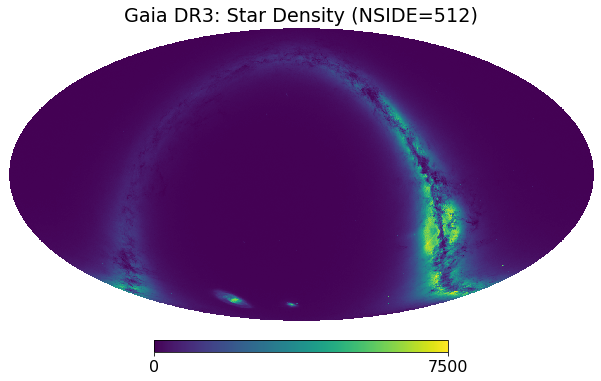

In [47]:
hp.mollview(filledpdf['count'].values,nest=True,title='Gaia DR3: Star Density (NSIDE=512)',xsize=2000)

#### Analyzing Parallax Values

In [48]:
%%time
n_negative_parallax = rawstardf.select('parallax').filter(F.col('parallax') < 0.0).count()
print(n_negative_parallax)

298359331
CPU times: user 39.5 ms, sys: 43.9 ms, total: 83.3 ms
Wall time: 916 ms


> About these negative parallaxes: <br> https://github.com/agabrown/astrometry-inference-tutorials/blob/master/luminosity-calibration/DemoNegativeParallax.ipynb

In [49]:
%%time
n_overone_parallax = rawstardf.select('parallax').filter(F.col('parallax') > 1000.0).count()
print(n_overone_parallax)

0
CPU times: user 36.7 ms, sys: 48.2 ms, total: 85 ms
Wall time: 587 ms


In [50]:
%%time
n_infinitesimal_parallax = rawstardf.select('parallax').filter(F.col('parallax') < 1.0-8).count()
print(n_overone_parallax)

0
CPU times: user 26.9 ms, sys: 69.6 ms, total: 96.6 ms
Wall time: 659 ms


> Overall, only negative parallaxes are problematic. 

#### Remove extreme parallax

In [51]:
%%time
stardf = rawstardf.filter((F.col('parallax') < 1000.0) & (F.col('parallax') > 1.0e-8))

CPU times: user 1.04 ms, sys: 261 µs, total: 1.3 ms
Wall time: 5.15 ms


> What is the fiducial limit of parallax? 1000 ~ 1e-8

In [52]:
%%time
stardf.select('parallax').count()

CPU times: user 31.4 ms, sys: 53 ms, total: 84.4 ms
Wall time: 697 ms


1006620092

In [53]:
#stardf.select('parallax').show(3)

#### Apply a short form of `lambda-udf `

In [54]:
import math

In [55]:
math.log10(10.0)

1.0

In [56]:
%time
getparsec = F.udf(lambda x: math.log10(1000.0/x), T.FloatType())
stardf = stardf.withColumn('logparsecs',getparsec(F.col('parallax')))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


> `np.log10()` should work. But the issue is its output type: `numpy.float` is not for pyspark's float. Hence, you have to write the code like this `float(np.log10(1000.0/x))` for explicitly converting the type.  

In [57]:
%%time
stardf.select('parallax','logparsecs').show(3)

+------------------+----------+
|          parallax|logparsecs|
+------------------+----------+
|0.3543305595550248| 3.4505913|
| 3.235017271512856| 2.4901235|
|3.1391701154499523|  2.503185|
+------------------+----------+
only showing top 3 rows

CPU times: user 632 µs, sys: 591 µs, total: 1.22 ms
Wall time: 69 ms


In [58]:
math.log10(1.0/0.3543305595550248)

0.45059138993670944

In [59]:
%%time
bins, counts = stardf.select('logparsecs').rdd.flatMap(lambda x: x).histogram(500)

CPU times: user 428 ms, sys: 313 ms, total: 741 ms
Wall time: 1min 24s


In [60]:
len(bins)

501

In [61]:
len(counts)

500

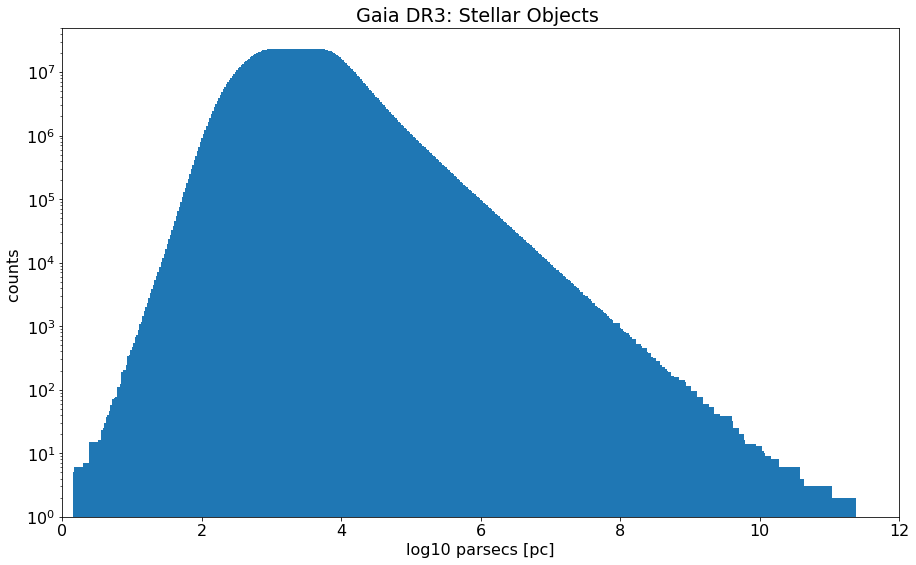

In [62]:
#bins, counts

#plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'


fig = plt.figure(figsize=(15,9))

plt.axis([0,12,1,5.0e7])
#plt.axes().set_aspect('equal', 'datalim')
plt.title(r'Gaia DR3: Stellar Objects ')
plt.xlabel(r'log10 parsecs [pc]')
plt.ylabel(r'counts ')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(bins[1:],counts)

plt.show()


#### MollView for non-negative parallaxes stars

In [63]:
starcountdf = stardf.groupBy('ipx512nested').agg(F.count("*").alias("count"))

In [64]:
%%time
tmppdf = starcountdf.orderBy('ipx512nested').toPandas().set_index('ipx512nested').reindex(full_index, fill_value=0)

CPU times: user 139 ms, sys: 85.2 ms, total: 224 ms
Wall time: 2.32 s


In [65]:
tmppdf

,count
0,19
1,25
2,33
3,31
4,18
...,...
3145723,155
3145724,138
3145725,154
3145726,142


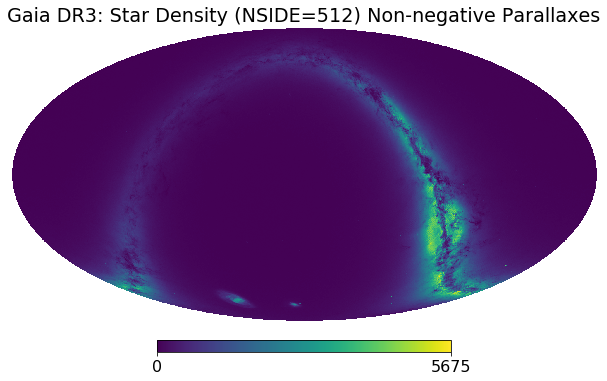

In [66]:
hp.mollview(tmppdf['count'].values,nest=True, \
            title='Gaia DR3: Star Density (NSIDE=512) Non-negative Parallaxes', \
            xsize=2000)

In [92]:
np.log10(500)

2.6989700043360187

#### Nearby Stars $< 500$ pc

In [93]:
nstardf = stardf.filter(F.col('logparsecs') < 2.6989700043360187)

In [94]:
nstardf.count()

45529065

In [95]:
nstarcountdf = nstardf.groupBy('ipx512nested').agg(F.count("*").alias("count"))

In [96]:
%%time
tmppdf = nstarcountdf.orderBy('ipx512nested').toPandas().set_index('ipx512nested').reindex(full_index, fill_value=0)

CPU times: user 178 ms, sys: 124 ms, total: 302 ms
Wall time: 16.5 s


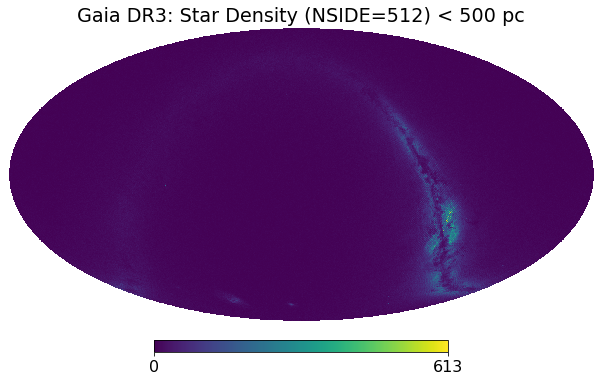

In [98]:
hp.mollview(tmppdf['count'].values,nest=True, \
            title='Gaia DR3: Star Density (NSIDE=512) < 500 pc', \
            xsize=2000)

#### Far away Stars > 1 Mpc

In [99]:
fstardf = stardf.filter(F.col('logparsecs') > 6.0)

In [100]:
fstardf.count()

773257

In [101]:
fstarcountdf = fstardf.groupBy('ipx512nested').agg(F.count("*").alias("count"))

In [102]:
%%time
tmppdf = fstarcountdf.orderBy('ipx512nested').toPandas().set_index('ipx512nested').reindex(full_index, fill_value=0)

CPU times: user 114 ms, sys: 120 ms, total: 234 ms
Wall time: 15.7 s


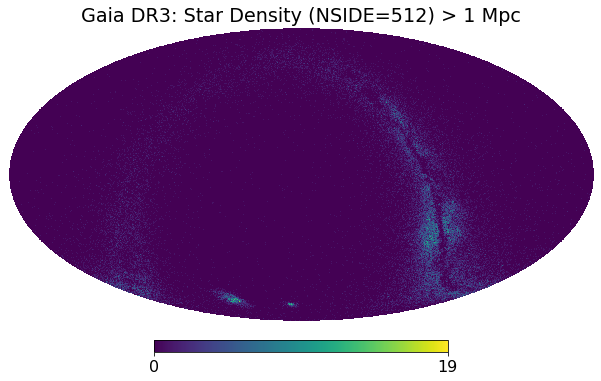

In [103]:
hp.mollview(tmppdf['count'].values,nest=True, \
            title='Gaia DR3: Star Density (NSIDE=512) > 1 Mpc', \
            xsize=2000)